# Load Generator Model and Make Predictions

In [1]:
import tensorflow as tf

import pathlib

from matplotlib import pyplot as plt

from tqdm import tqdm
import numpy as np

from utils import *
from pix2pix_model import *
from losses import *

# Load Dataset.

In [2]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]

In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [4]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Load Generator.

# Load Generators and Generated Predictions

In [5]:
model_dir = 'models'
model_files = [model_file for model_file in pathlib.Path(model_dir).iterdir() if model_file.suffix=='.h5']
model_files

[WindowsPath('models/generator_facades_alpha=1_nsteps=160k.h5'),
 WindowsPath('models/generator_facades_alpha=2.5_nsteps=160k.h5'),
 WindowsPath('models/generator_facades_alpha=2_nsteps=160k.h5'),
 WindowsPath('models/generator_facades_alpha=3.5_nsteps=160k.h5'),
 WindowsPath('models/generator_facades_alpha=3_nsteps=160k.h5'),
 WindowsPath('models/generator_facades_alpha=4_nsteps=160k.h5')]

In [6]:
def create_predictions(generator, dataset):
    segmentation_masks = []
    generated_images = []

    for inp, tar in tqdm(dataset, leave=False):
        segmentation_masks.append(inp[0])

        generated_img = generator(inp, training=True)
        generated_images.append(generated_img[0])

    segmentation_masks = np.array(segmentation_masks)
    generated_images = np.array(generated_images)

    return segmentation_masks, generated_images

def plot_sample(seg_masks, gen_imgs):

    rand_indx = np.random.randint(0, len(gen_imgs))

    seg_mask = seg_masks[rand_indx]
    gen_img = gen_imgs[rand_indx]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    ax1.imshow(seg_mask*0.5 + 0.5)
    ax2.imshow(gen_img*0.5 + 0.5)

def save_data(test_segmentation_masks, test_generated_images, train_segmentation_masks, train_generated_images, savefile_name):
    data_dict = {'test_segmentation_masks': test_segmentation_masks, 'test_generated_images': test_generated_images,
                    'train_segmentation_masks': train_segmentation_masks, 'train_generated_images': train_generated_images}

    filename = f'predictions/{savefile_name}.npy'
    np.save(filename, data_dict)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:00<05:00, 60.14s/it]

 33%|███▎      | 2/6 [02:01<04:04, 61.02s/it]

 50%|█████     | 3/6 [03:10<03:13, 64.64s/it]

 67%|██████▋   | 4/6 [04:18<02:11, 65.75s/it]

 83%|████████▎ | 5/6 [05:12<01:01, 61.70s/it]

100%|██████████| 6/6 [06:06<00:00, 61.15s/it]


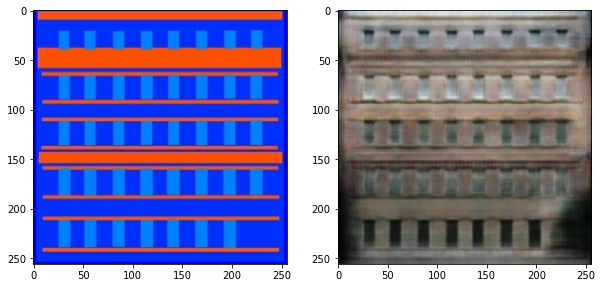

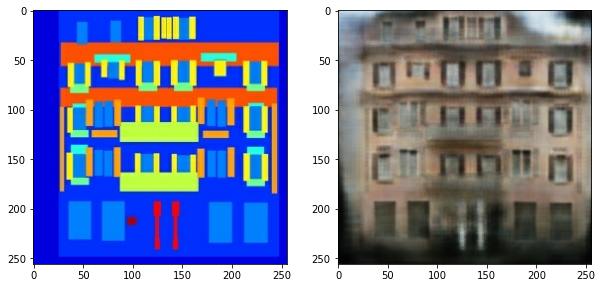

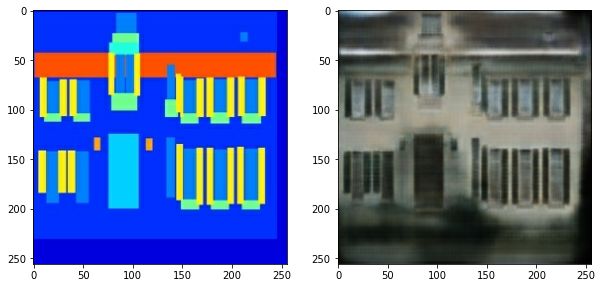

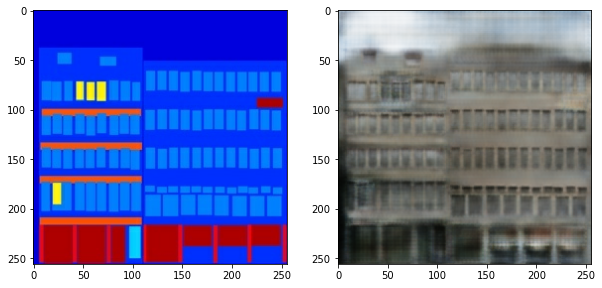

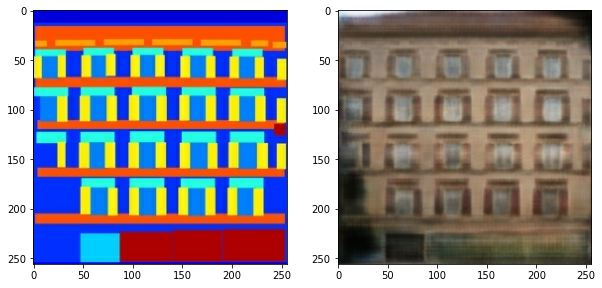

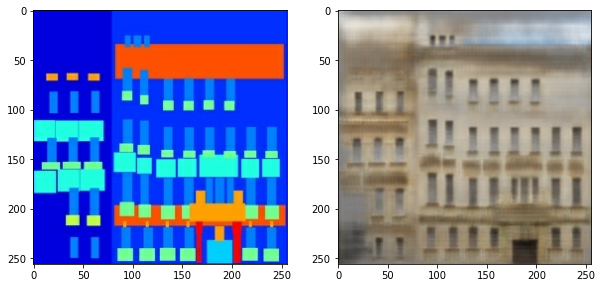

In [7]:
for model_file in tqdm(model_files):
    gen = tf.keras.models.load_model(model_file)
    savefile_name = str(model_file)[17:-3]

    test_segmentation_masks, test_generated_images = create_predictions(gen, test_dataset)
    train_segmentation_masks, train_generated_images = create_predictions(gen, test_dataset)

    plot_sample(test_segmentation_masks, test_generated_images)

    save_data(test_segmentation_masks, test_generated_images, train_segmentation_masks, train_generated_images, savefile_name)
